<a href="https://colab.research.google.com/github/nochwysid/CSE5008-SP/blob/main/MichailSeth_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2

Due Date : May 20th, 11:59 PM

In this assignment, you'll load and play with CO2 data collected at the [Mauna Loa observatory](https://en.wikipedia.org/wiki/Mauna_Loa_Observatory) over the last 60 years. We will also be using the [El Nino Index](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php) dataset that records the temperature changes due to the [El Nino](https://en.wikipedia.org/wiki/El_Niño) effect. We will try to apply some of the methods we learnt in class on these datasets.

Links for more information about the datset we are using
* NOAA Website: https://www.esrl.noaa.gov/gmd/ccgg/trends/full.html
* NOAA data: https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html

The monthly data can be found at this [link](ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt)
You can run the cells below to download the dataset.

Note: For fill-in cells that mention a number of lines of code, it is just to indicate that it is possible in that many lines, do not worry if you use more lines than that. Use it as an enouragement to learn how to do it in fewer lines as that will introduce you to useful techniques. Plot saving commands and printing commands are not included in the count.

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [205]:
df = pd.read_csv('http://web.stanford.edu/class/cme193/uploads/co2_mm_mlo.txt', 
                  delim_whitespace=True, 
                  comment='#',
                  names=["year", "month", "decdate", "co2", "co2interp", "trend", "days"])

pd.set_option('display.max_rows', 10)

## Question 1 - Clean the data

The dataframe currently contains columns called `year` and `month`. The goal is to introduce a new column called `date` that combines the year and month into one column. To do this, we will use a Pandas built-in function called `pd.to_datetime`, which accepts as its first argument a dataframe with three columns, `month`, `day`, and `year`, and outputs a dataframe with a single column corresponding to the date. 

First, create a column called `day` in the dataframe `df`, and set it equal to `1` for all rows. (This is so that, for example, the row with year 1958 and month 3 will be treated as March 1, 1958.)

In [206]:
# YOUR CODE HERE (1 lines, but feel free to also print df if you'd like)
df['day'] = 1
df.head()

,year,month,decdate,co2,co2interp,trend,days,day
0,1958,3,1958.208,315.71,315.71,314.62,-1,1
1,1958,4,1958.292,317.45,317.45,315.29,-1,1
2,1958,5,1958.375,317.50,317.50,314.71,-1,1
3,1958,6,1958.458,-99.99,317.10,314.85,-1,1
4,1958,7,1958.542,315.86,315.86,314.98,-1,1


Next, select the three columns `month`, `day`, and `year` from `df` and pass the resulting three-column dataframe to `pd.to_datetime`. Create a new column `date` in `df` and set it equal to the output of `pd.to_datetime` to create a new column corresponding to the date.

In [207]:
# YOUR CODE HERE (1 line)
df['date'] = pd.to_datetime({'month':df['month'], 'day':df['day'], 'year':df['year']})

From this point onward, we only care about the columns `date`, `co2`, and `trend`. Select only these columns and discard everything else.

In [208]:
# YOUR CODE HERE (1 line)
df2 = pd.DataFrame({'date':df['date'], 'co2':df['co2'], 'trend':df['trend']})

In [209]:
df2.head()

,date,co2,trend
0,1958-03-01,315.71,314.62
1,1958-04-01,317.45,315.29
2,1958-05-01,317.50,314.71
3,1958-06-01,-99.99,314.85
4,1958-07-01,315.86,314.98


In [210]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    745 non-null    datetime64[ns]
 1   co2     745 non-null    float64       
 2   trend   745 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 17.6 KB
None


Set the index to `date` (use `df.set_index` and overwrite `df` with the return value).

In [211]:
# YOUR CODE HERE (1 line)
df2 = df2.set_index(df2['date'])

Plot the data by using `df.plot()`. What do you notice?

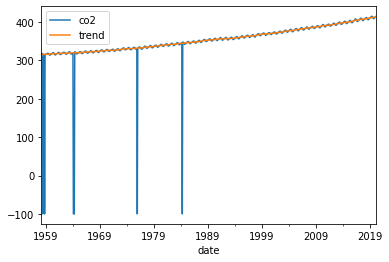

In [212]:
# YOUR CODE HERE (1 line)
df2.plot(x='date')

The dataset uses -99.99 in the `co2` column to denote missing data. Set these values to `None` instead.

In [213]:
# YOUR CODE HERE (1 line)
df2.loc[df2['co2'] == -99.99] = None

Now, use the [`Series.interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) function to fill in the missing data. Look at the example in the documentation to see how it works.

In [214]:
# YOUR CODE HERE (1 line)
df2 = df2.interpolate(method='pad')# only 'pad' and 'bfill' are supported, why even bother?

Plot the data again (`df.plot()`). Is the problem solved?

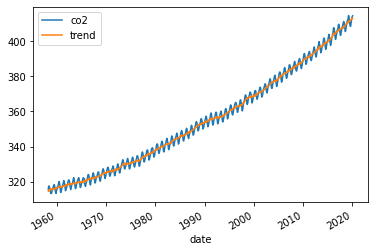

In [215]:
# YOUR CODE HERE (1 line)
df2.plot(x='date')

Save the above plot as `qsn1.png`.

Now plot only the data since 2008 (by selecting only the rows after 2008). You can slice based only on the year as follows `df['2008':]` You should be able to see the seasonal variation more clearly.

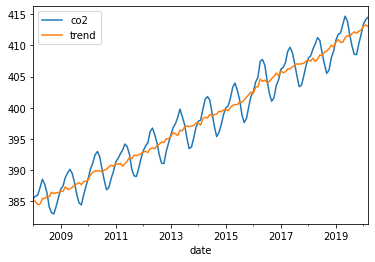

In [216]:
# YOUR CODE HERE (1 line)
df2['2008':].plot(x='date')

## Question 2 - Fit a curve

Next we want to fit the data with a curve of specific functional form. Before we do that we need the time in some numeric format so that we can calculate functions on it.

Create a column called `float_time` to represent the floating point value of the year. As an example 1st July 2009 will be 2009.5 , as it represents the middle of the year. To do this use `df.index.month` and `df.index.year` to create the formula that represents time as a decimal number of years.

In [217]:
# YOUR CODE HERE (1 line)
df2['float_time'] = df2.index.year + (1 - 1/df2.index.month)

Next create a function to represent the curve that we want to use to fit the data, it should represent the following mathematical function. We are going to use an exponential curve.

$$ f(t) = a+ be^{c(t-1900)}$$

It has three parameters a,b,c

In [218]:
from math import exp
def dc_helper(d, a, b, c):
  return a + b*exp( c*(d - 1957) )

In [219]:
# YOUR CODE HERE (2 lines) 
from math import exp
#t = df2['float_time']
def date_curve(t, a, b, c):
  return np.asarray([dc_helper(d, a, b, c) for d in t])

Use the `scipy.optimize` library to fit this curve to the `trend` column in the dataset. You may need to play around with the initial guesses to make sure the curve is correctly fit.

Hint: Try to plot the trend curve and the model curve with some parameters you choose by hand. Now modify the guesses until the model curve roughly fits the trend curve. Think of this as a sort of "manual" fitting step before you refine your guesses using scipy.

In [220]:
import scipy.optimize as opt

In [221]:
 # YOUR CODE HERE (1 line)
((a,b,c),_) = opt.curve_fit(date_curve, df2['float_time'], df2['trend'], (257,55,0.01))
# _ is covariance matrix, shape (3,3)
print(a,b,c)

257.33540741759737 55.0261504346613 0.016374228631820083


Create a new column called `curve_fit` and store the curve that you fit above.

In [222]:
# YOUR CODE HERE (1 line)
df2['curve_fit'] = date_curve(df2['float_time'],a,b,c)

Plot both the fitted curve values and the CO2 trend values in the same plot. Save the plot as `qsn2.png`

In [223]:
# YOUR CODE HERE (1 line)
df3 = pd.DataFrame( {'fit':list(df2['curve_fit']), 'co2':list(df2['co2'])}, index = df2['float_time'])

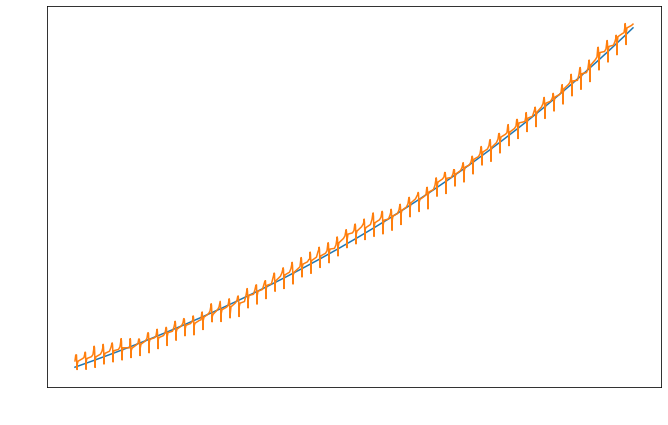

In [224]:
fig, ax = plt.subplots(figsize=(11,7))
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM").set_color("#FFFFFF")
ax.tick_params(colors="#FFFFFF")
ax.plot(df3)

Does it match? If it does not you need to tweak the initial values of the model parameters untill both the curves are almost coincident.

## Question 3 - Make a prediction

The CO2 level crossed the 400 ppm level around 2013. In this question we want to find out when according to our naive curve model, will it cross 500 ppm?

Use the `scipy.optimize` package's root finding functions to find when will your curve cross the 500ppm threshold mark.

Hint: You can do the following in one line, using lambda functions

In [225]:
intercept = 1957 + np.log((400 - a)/ b)/c 
intercept

2015.182150473851

In [226]:
#solving manually
intercept = 1957 + np.log((500 - a)/ b)/c 
intercept

2047.622386624888

In [227]:
dc_helper(2047.622386624888, a, b, c)

500.0000000000003

In [228]:
# YOUR CODE HERE (1 line)
out = opt.root(date_curve, 2052.166239, (a,b,c))
#x should be near zero if input date is correct
out

    fjac: array([[1.]])
     fun: array([257.33540742])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 17
     qtf: array([257.33540742])
       r: array([9.01348764e-12])
  status: 5
 success: False
       x: array([1.5000532e-06])

In [229]:
#but it's off by about 4.5 years
opt.root(date_curve, 2047.622386624888, (a,b,c))

    fjac: array([[1.]])
     fun: array([257.33540742])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 17
     qtf: array([257.33540742])
       r: array([9.15221992e-13])
  status: 5
 success: False
       x: array([-176.59274074])

In [230]:
df2.head()

,date,co2,trend,float_time,curve_fit
date,,,,,
1958-03-01,1958-03-01,315.71,314.62,1958.666667,313.883921
1958-04-01,1958-04-01,317.45,315.29,1958.750000,313.961135
1958-05-01,1958-05-01,317.50,314.71,1958.800000,314.007514
1958-06-01,1958-05-01,317.50,314.71,1958.833333,314.038455
1958-07-01,1958-07-01,315.86,314.98,1958.857143,314.060565


Plot the CO2 trend along with the prediction values upto the year it would reach 500ppm. You should see two curves, one is the data till 2019 and the other should entend all the way upto the year you predicted that CO2 will cross 500pm. Caption your plot with your model's prediction for when CO2 crosses 500ppm, and save the graph as `qsn3.png`.

Hint: You may find it easier to plot using matplotlib plot directly rather than using `df.plot` in this case. Create a linspace from the starting year to the year you predicted to use as the x-axis of the plot.

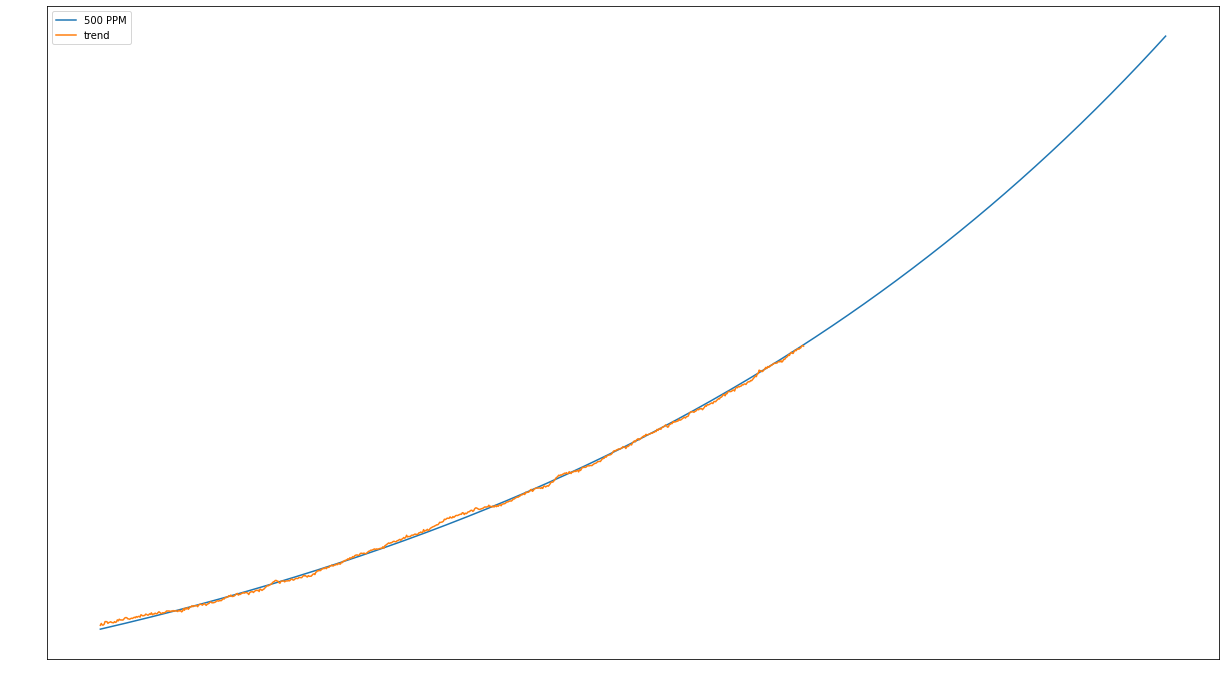

In [231]:
# YOUR CODE HERE (~4 lines)
out
xaxis = np.linspace(1958, 2053, 12*94)
fiver = date_curve(xaxis,a,b,c)
basic = np.asarray(df2['trend'].values)

fig, ax = plt.subplots(figsize=(21,12))
ax.set_xbound(lower=1958, upper=2053)
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM difference").set_color("#FFFFFF")
ax.tick_params(colors="#FFFFFF")
ax.plot(fiver,label="500 PPM")
ax.plot(basic,label="trend")
plt.legend()

## Question 4 - Explain the variation

We will now use the curve-fit model that we created earlier to subtract the general increasing trend we see from the CO2 levels. This will allow us to study the more subtle changes in the CO2 levels. In particular we will try to explain these small changes using the [El Nino](https://en.wikipedia.org/wiki/El_Niño) phenomenon. It is a cyclic phenomenon that makes certain winters warmer than usual. We want to see if it can explain the subtle variations in the CO2 levels over and above the general exponential trend. There can be many reasons why the warmer winters might affect the the CO2 levels, including complicated biological reasons such as change in vegetation cover etc, but also man-made reasons such as decreased energy conumption due to reduction in requirement of internal heating. We will use a dataset for the Ocean Nino Index (ONI) which has monthly values just like the CO2 dataset.

Download the dataset by running the cell below. You can read more about this data [here](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php). The SEAS column represents the first letters of the three consecutive months for which the average is taken. For example Jan Feb March will be JFM, We will consider that to be February's value, i.e. the middle month.

In [232]:
oni_df = pd.read_csv('http://web.stanford.edu/class/cme193/uploads/oni.ascii.txt', 
                  delim_whitespace=True)

oni_df

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07
...,...,...,...,...
858,JJA,2021,26.90,-0.39
859,JAS,2021,26.47,-0.49
860,ASO,2021,26.09,-0.67
861,SON,2021,25.90,-0.82


Store the difference between the `trend` column and the `curve_fit` column in a column called `co2_variation`. This column shows how the CO2 level deviated from the curve model in a particular month. Plot it. You should see that max and min deviation is around +2 and -2 ppm. If not you may need to revisit the curve fitting again.

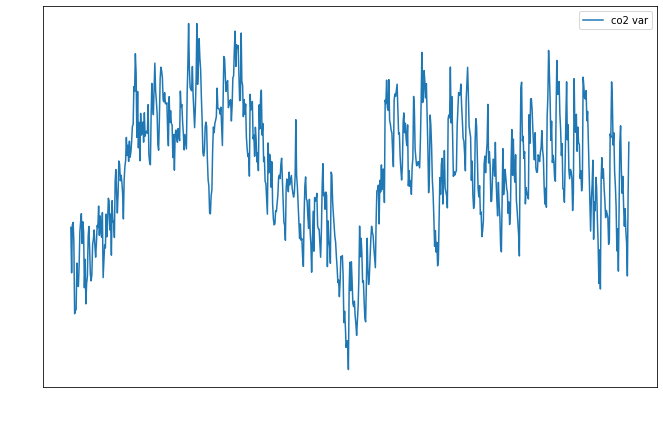

In [233]:
# YOUR CODE HERE 
df2['co2_variation'] = df2['curve_fit'] - df2['trend']

fig, ax = plt.subplots(figsize=(11,7))
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM difference").set_color("#FFFFFF")
ax.tick_params(colors="#FFFFFF")
ax.plot(df2['co2_variation'],label="co2 var")
plt.legend()

Now the task is to find a common set of dates between the datasets (`df` and `oni_df`), to perform the analysis on. In this particular case that can be easily done manually. Store the aligned CO2 levels dataframe in a variable called `df_sub` and the ONI values dataframe in a variable called `oni_df_sub`. They should have same number of rows and the rows should represent the same months.

In [234]:
# YOUR CODE HERE 
#oni_df[98] aligns df2[0]
odf = oni_df[98:843]
odf = odf.reset_index()
odf = odf.drop(columns='index')
oni_df_sub = odf.copy()
df_sub = df2.copy()

The below output should show the same start and end dates, if they are properly aligned

In [235]:
print(oni_df_sub[['SEAS','YR']].iloc[[0,-1]])
print(df_sub.index[[0,-1]])

    SEAS    YR
0    FMA  1958
744  FMA  2020
DatetimeIndex(['1958-03-01', '2020-03-01'], dtype='datetime64[ns]', name='date', freq=None)


We can now extract the values into numpy arrays to use for regression

In [236]:
y = df_sub['co2_variation'].values
x = oni_df_sub['ANOM'].values

Let us now train a linear regression model to see if we can predict the CO2 variation using the ONI values. Since this is a time series and there can be historical dependence, we want to use the time shifted values of `x` as features to predict `y`. We want our prediction of the CO2 variation to linearly depend on the ONI values for the last year (12 months). This is called an [Autoregressive Model](https://en.wikipedia.org/wiki/Autoregressive_model)

Write a function called `featurize(x,d)` that returns a matrix of `d` columns, where each column is a time shifted version of `x`. The first column would be `x` itself, the second one will be `x` delayed by one (shifted down by 1, time increases as you go down) and so on till column `d`. Since the earliest `d-1` values do not have enough history, we can ignore such rows, thus the return value will have `d-1` fewer rows. Compare the output of your function to the example output below to make sure it is working correctly.

In [237]:
def featurize(x,d):
  start = 0
  end = d
  arr = []
  while end < len(x)+1:
    tmp = x[start:end]
    arr.append(tmp[::-1])
    start += 1
    end += 1
  return np.asarray(arr)

In [238]:
inp1 = 0.1*np.arange(10)
print("Input = ",inp1,"\n")
print("Output = \n",featurize(inp1,4), "\n")

Input =  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] 

Output = 
 [[0.3 0.2 0.1 0. ]
 [0.4 0.3 0.2 0.1]
 [0.5 0.4 0.3 0.2]
 [0.6 0.5 0.4 0.3]
 [0.7 0.6 0.5 0.4]
 [0.8 0.7 0.6 0.5]
 [0.9 0.8 0.7 0.6]] 



Expected output is 
```
Input =  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] 

Output = 
 [[0.3 0.2 0.1 0. ]
 [0.4 0.3 0.2 0.1]
 [0.5 0.4 0.3 0.2]
 [0.6 0.5 0.4 0.3]
 [0.7 0.6 0.5 0.4]
 [0.8 0.7 0.6 0.5]
 [0.9 0.8 0.7 0.6]]

```

Now use d=12 to featurize the `x` values and train a linear regression model to predict `y`. Remember you need to truncate `y` as well to ensure they are the same size.

In [239]:
# YOUR CODE HERE 
import numpy as np
# exact implementation not specified and many options available
from sklearn.linear_model import LinearRegression as LRM
# as from above, and rearranging, fx will have shape (x+1-d, d)
fx = featurize(x,12)
# truncate y to length x+1-d
y = y[11:]
lr_model = LRM()
lr_model.fit(fx, y)

LinearRegression()

Now store the regression predictions in a column called "ONI_regression" and plot both the "ONI_regression" and "co2_variation" columns in the same plot. Does the regression actually capture the variation in CO2 levels?

To be more principled, use `scipy.stats.pearsonr` to compute the [Peasrson's R coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the "ONI_regression" and "co2_variation" columns and display the value in the title of the graph.

In [247]:
# YOUR CODE HERE 
from scipy.stats import pearsonr as pr
v = [0,0,0,0,0,0,0,0,0,0,0] #preppend
v.extend(list(lr_model.predict(fx)))

#v = [0,0,0,0,0,0]
#v.extend(list(lr_model.predict(fx)))
#v.extend([0,0,0,0,0])

#v = list(lr_model.predict(fx))
#v.extend([0,0,0,0,0,0,0,0,0,0,0]) #append

oni_df_sub['ONI_regression'] = v
r = pr(df_sub['co2_variation'], oni_df_sub['ONI_regression'])

""" This step is necessary to avoid a runtime error """
df_sub['ONI_regression'] = oni_df_sub['ONI_regression'].values

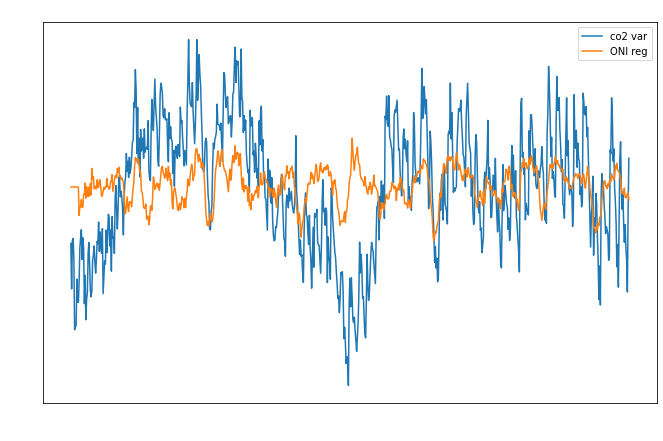

In [248]:
fig, ax = plt.subplots(figsize=(11,7))
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM").set_color("#FFFFFF")

ax.tick_params(colors="#FFFFFF")
ax.plot(df_sub['co2_variation'],label="co2 var")
ax.plot(df_sub['ONI_regression'],label="ONI reg")
ax.set_title(f"Pearson R: {r}").set_color("#FFFFFF")
plt.legend()

If you look at the above graph closely you should see that indeed some of the peaks can be captured through the regression model. The predictions should be better in the later years after 1995. In order to confirm that, plot from 1995 onwards and recompute the pearson coefficient for this time period and put it in the title of the plot. You should get a higher value of the coefficient now. Save this plot as `qsn4.png`.

In [249]:
df9 = pd.DataFrame(index=df2['date'][440:])
df9['ONI_regression'] = oni_df_sub['ONI_regression'][440:].values
df9['co2_variation'] = df_sub['co2_variation'][440:].values
df9r = pr(df9['ONI_regression'], df9['co2_variation'])

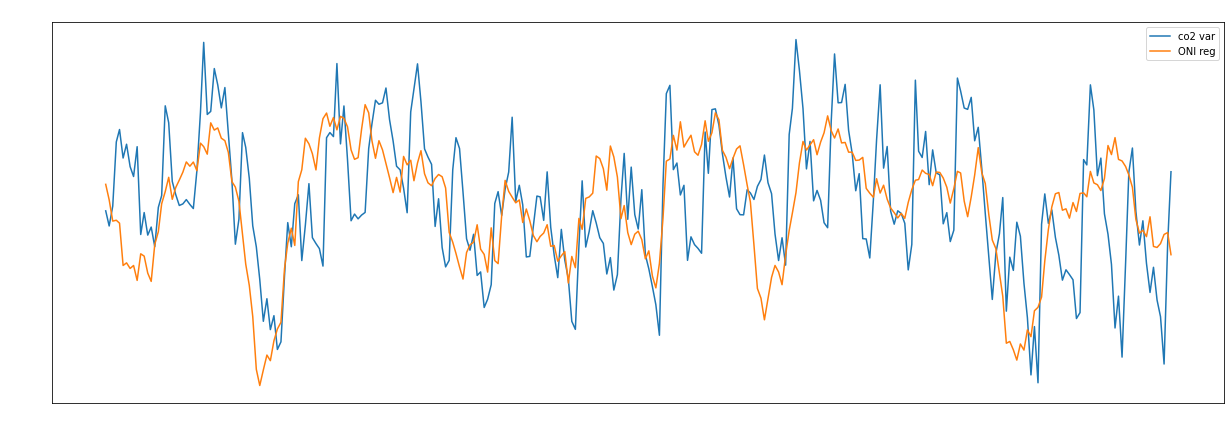

In [250]:
fig, ax = plt.subplots(figsize=(21,7))
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM").set_color("#FFFFFF")

ax.tick_params(colors="#FFFFFF")
ax.plot(0.45*df_sub['co2_variation'][440:],label="co2 var")
ax.plot(df_sub['ONI_regression'][440:],label="ONI reg")
ax.set_title(f"Pearson R: {df9r}").set_color("#FFFFFF")
plt.legend()

In [251]:
df7 = pd.DataFrame(df2['co2'][10:].values,columns={'co2'})
df7['trend-fit'] = df2['co2_variation'][10:].values#trend-curve_fit
df7['ANOM'] = oni_df_sub['ANOM'][10:].values
df7['ONI_regression'] = v[10:]
df7['ONI_reverse'] = list(df7['ONI_regression'])[::-1]
df7['anom-co2var'] = ((df7['ANOM'] - df7['trend-fit'])/(-7)).values
df7 = df7.reset_index(drop=True)

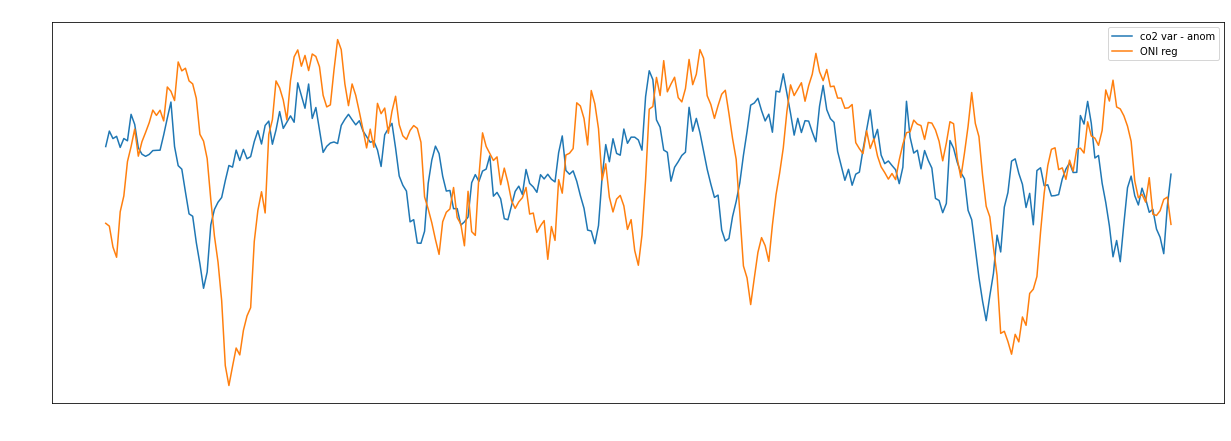

In [252]:
aor = pr(df7['anom-co2var'][440:],df7['ONI_regression'][440:])

fig, ax = plt.subplots(figsize=(21,7))
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM").set_color("#FFFFFF")

ax.tick_params(colors="#FFFFFF")
ax.plot(df7['anom-co2var'][440:],label="co2 var - anom")
ax.plot(df7['ONI_regression'][440:],label="ONI reg")
#ax.plot(0.5*df7['ONI_reverse'][440:],label="ONI reversed")
ax.set_title(f"Pearson R: {aor}").set_color("#FFFFFF")
plt.legend()

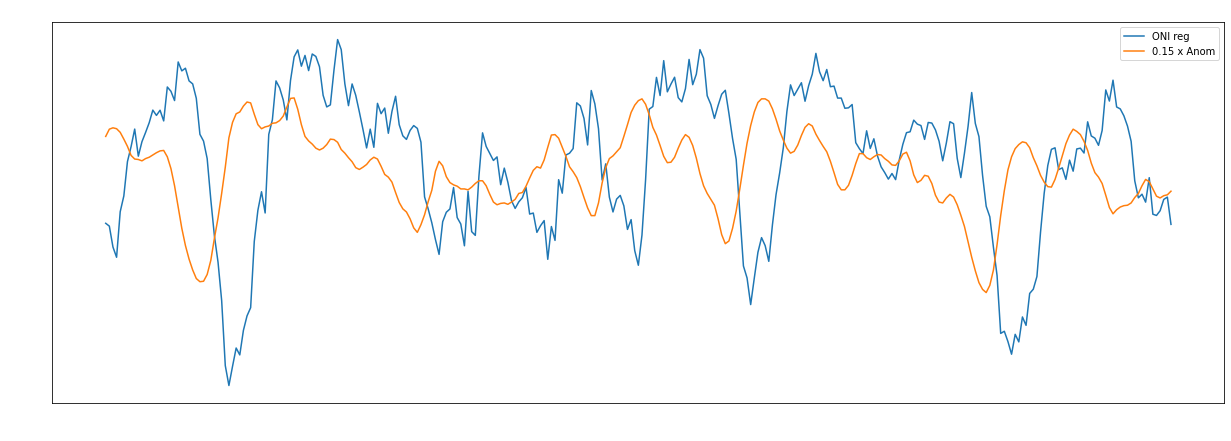

In [253]:
ghp = pr(-0.15 * df7['ANOM'][440:],df7['ONI_regression'][440:])

fig, ax = plt.subplots(figsize=(21,7))
ax.set_xlabel("Year").set_color("#FFFFFF")
ax.set_ylabel("PPM diff").set_color("#FFFFFF")
ax.set_title(f"Pearson R: {ghp}").set_color("#FFFFFF")

ax.tick_params(colors="#FFFFFF")
ax.plot(df7['ONI_regression'][440:],label="ONI reg")
ax.plot( -0.15 * df7['ANOM'][440:],label="0.15 x Anom")

plt.legend()

# Submission Instructions

You need to submit the following in canvas
1. This notebook with the code filled in for each question
2. The figures
    1. qsn1.png
    2. qsn2.png
    3. qsn3.png
    4. qsn4.png
